# Archivos BigData

En los datalake generalmente veremos archivos guardados en los formatos AVRO, Parquet u ORC. 
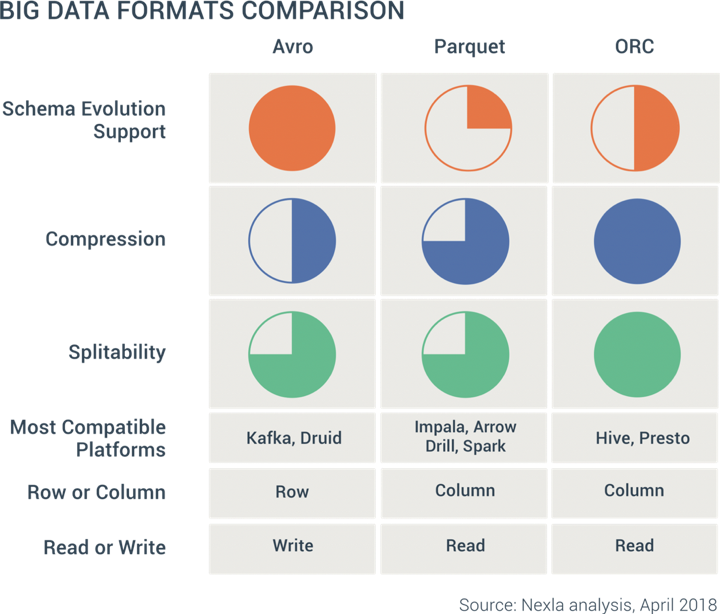

### Variables
Se utilizo la siguiente variable para indicar donde dejar los archivos guardados.

In [28]:
#Agregar una ruta en tu equipo
path ="C:\\"

# Avro

- Almacena la data en filas. Esto lo hace bueno para grandes cargas de escritura transaccional.
- Soporta serialización.
- Rápido formato binario. y divisible.
- Compresión de bloques.
- Almacena el esquema en la cabecera.

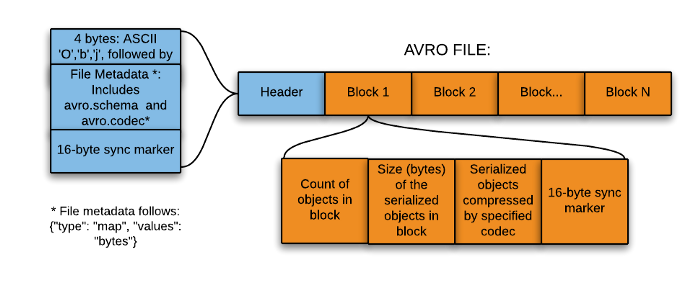

Para utilizar este formato en Avro se debe instalar el módulo Avro

In [1]:
pip install avro

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for avro: filename=avro-1.11.0-py2.py3-none-any.whl size=115925 sha256=4d14b79c8106739cb42267c9276be1c65af9162d0ade2a535469298f182d1eed
  Stored in directory: c:\users\saezr\appdata\local\pip\cache\wheels\9a\a5\9b\d100e4bd3ef9697b2f955616260c77cb136f8cd2fc89533c63
Successfully built avro
Note: you may need to restart the kernel to use updated packages.


### Librerías
Avro requiere un esquema el que puede generarse en el código o importarse desde un fichero.

In [2]:
import avro.schema

#### Crear esquema en código

In [16]:
schema = avro.schema.parse(json.dumps({
 "namespace"    : "example.avro",
 "type"         : "record",
 "name"         : "User",
 "fields"       : [
     {"name": "name"            , "type": "string"},
     {"name": "lastname"            , "type": ["string","null"]},
     {"name": "personal number" , "type": "string"}
 ]
}))

#### Leer esquema desde archivo

In [4]:
schema = avro.schema.parse(open(path+"avro_schema.avsc").read())

#### Ejemplo creación de archivo con esquema

In [3]:
f = open(path+"avro_schema.avsc", "w")
f.write('''
{
 "namespace"    : "example.avro",
 "type"         : "record",
 "name"         : "User",
 "fields"       : [
     {"name": "name"            , "type": "string"},
     {"name": "lastname"            , "type": ["string","null"]},
     {"name": "personal number" , "type": "string"}
 ]
}
''')
f.close()



#### Creación y escritura de archivos

In [7]:
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter

writer = DataFileWriter(open(path+"users.avro", "wb"), DatumWriter(), schema)
writer.append({"name": "Pedro", "lastname": "Pérez","personal number":"11.111.111"})
writer.append({"name": "Pablo", "lastname": "Cabello","personal number":"22.222.222"})
writer.append({"name": "Paola", "lastname": "Muñoz","personal number":"33.333.333-3"})
writer.close()

reader = DataFileReader(open(path+"users.avro", "rb"), DatumReader())

for user in reader:
    print(user)
    print('===================')
reader.close()

{'name': 'Pedro', 'lastname': 'Pérez', 'personal number': '11.111.111'}
{'name': 'Pablo', 'lastname': 'Cabello', 'personal number': '22.222.222'}
{'name': 'Paola', 'lastname': 'Muñoz', 'personal number': '33.333.333-3'}


# Parquet
- Almacena la data en columnas
- Alta compresión
- Buscará solo columnas requeridas lo que reduce las E/S
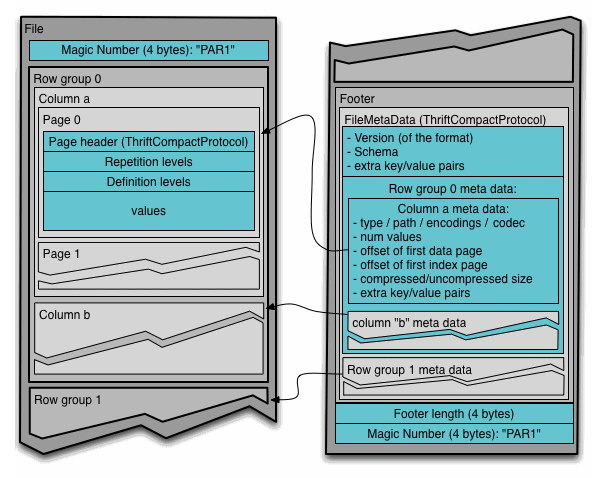

Puede utilizarse el módulo pyarrow para crear archivos Parquet

In [2]:
pip install pyarrow

In [3]:
pip install pandas

### Librerías

In [1]:
import pyarrow.parquet as pq

In [2]:
import pyarrow as pa

In [3]:
import pandas as pd

#### Creación desde un dataframe

In [4]:
df = pd.DataFrame(columns =['name','lastname','personal number'])

In [5]:
df = df.append({'name':'Pedro','lastname':'Pérez','personal number':'11.111.111-1'}, ignore_index = True) 
df = df.append({'name':'Pablo','lastname':'Cabello','personal number':'22.222.222-2'}, ignore_index = True) 
df = df.append({'name':'Paola','lastname':'Muñoz','personal number':'33.333.333-3'}, ignore_index = True) 

In [6]:
df

,name,lastname,personal number
0,Pedro,Pérez,11.111.111-1
1,Pablo,Cabello,22.222.222-2
2,Paola,Muñoz,33.333.333-3


In [7]:
table = pa.Table.from_pandas(df)

In [10]:
pq.write_table(table, path+'users.parquet')

#### Lectura de Parquet

In [11]:
pq.read_table(path+'users.parquet')

pyarrow.Table
name: string
lastname: string
personal number: string
----
name: [["Pedro","Pablo","Paola"]]
lastname: [["Pérez","Cabello","Muñoz"]]
personal number: [["11.111.111-1","22.222.222-2","33.333.333-3"]]

In [12]:
pq.read_pandas(path+'users.parquet', columns=['name']).to_pandas()

,name
0,Pedro
1,Pablo
2,Paola


# Formato ORC

- Orientado a columnas
- Alta compresión
- Soporta tipos de Hive (datetime, decimal.list, map)
- Permite agregar o quitar campos
- Compatible con HiveQL
- Soporta serialización
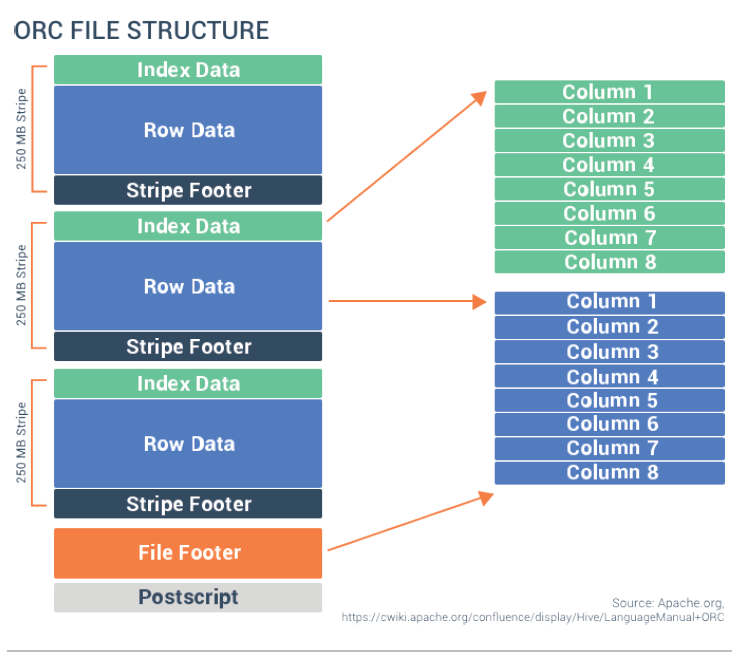

In [5]:
pip install pyorc

Note: you may need to restart the kernel to use updated packages.


### Librerías

In [6]:
import pyorc

#### Creación de archivo

In [10]:
output = open(path+"user.orc", "wb")
writer = pyorc.Writer(output, "struct<name:string,lastname:string,personal_number:string>")
writer.write(("Pedro", "Pérez","11.111.111-1"))
writer.write(("Pablo", "Cabello","22.222.222-2"))
writer.write(("Paola", "Muñoz","33.333.333-3"))
writer.close()

#### Lectura

In [11]:
example = open(path+"user.orc", "rb")
reader = pyorc.Reader(example)

In [12]:
str(reader.schema)

'struct<name:string,lastname:string,personal_number:string>'

In [13]:
len(reader)

3

In [14]:
next(reader)

('Pedro', 'Pérez', '11.111.111-1')

In [15]:
next(reader)

('Pablo', 'Cabello', '22.222.222-2')

In [18]:
#Para ir a una ubicación del archivo
reader.seek(0)

0

In [19]:
next(reader)

('Pedro', 'Pérez', '11.111.111-1')

#### Como la data esta almacenada en franjas tambien pueden iterarse a nivel de estas.

In [20]:
reader.num_of_stripes

1

In [22]:
stripe = reader.read_stripe(0)

In [24]:
len(stripe)

3

In [25]:
next(stripe)

('Pedro', 'Pérez', '11.111.111-1')